# Set up environment

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# Test if GPU is available
# Note that CUDA below 12.1 can have bugs
import torch
print(torch.cuda.is_available())
# print(torch.cuda.get_device_name(0))
print(torch.version.cuda)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

True
12.1


In [3]:
#%% import libraries
import os
from collections import defaultdict
import sys

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import copy
import numpy as np
import numpy.random
from numpy.fft import fft as fft
from numpy.fft import ifft as ifft
import pickle
from sklearn.linear_model import PoissonRegressor
from sklearn.model_selection import KFold
from sklearn.manifold import TSNE
import scipy.stats
from scipy.stats import wilcoxon, chi2
import scipy.interpolate 
import scipy.signal
from scipy import linalg
from scipy.special import rel_entr
from tqdm import tqdm
import pandas as pd
import joblib
import logging

import statsmodels.api as sm
import statsmodels.genmod.generalized_linear_model as smm

import torch
from torch.autograd import Variable
from torch.nn import functional as F
import torch.nn as nn
import torch.optim as optim

In [4]:
# import my code
import utility_functions as utils
import GLM
from DataLoader import Allen_dataset, Allen_dataloader_multi_session, Simple_dataloader_from_spikes
from model_trainer import Trainer

/home/qix/anaconda3/envs/allen/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Generate synthetic data

In [181]:
spikes, trial_type = GLM.EIF_simulator(
    std1=10, corr1=0.0, std2=10, corr2=0.0, ntrial=2000, nneuron=20, conn=0.01,
    use_two_modes=True,
    return_trial_type=True
)

print(f"Size of spikes array in MB: {spikes.nbytes / (1024 * 1024):.2f} MB")


100%|██████████| 2000/2000 [02:47<00:00, 11.92it/s]

Size of spikes array in MB: 91.55 MB


In [182]:
synthetic_dataloader = Simple_dataloader_from_spikes(
    [spikes[:,:10,:], spikes[:,10:,:]],
    npadding=50,
    train_ratio=0.7,
    val_ratio=0.1,
    batch_size=64,
    verbose=True
)

In [183]:
for batch in synthetic_dataloader.train_loader:
    print(batch['spike_trains'].shape)
    break

torch.Size([300, 20, 64])


# Train a model

Current problems:
- Not stable! Run the code multiple times, the results are different. **Solved by temporal correlation penalty**
- The coupling effect is not capturing what it should capture. ** **

Things I want to try:
- see if the baseline looks good. **YES**
- I want to get a clear two modes in t-sne plot, since the ground truth is two modes. **YES**
- Play with hyperparameters, see what appect the results. **lr is still very important. Epoch is also important.**
- Try make coupling effect weaker by setting initial value to be around zero. I don't want to see the coupling effect being too strong. **can be done by frozing Transformer encoder**
- See how would overlapping penalty affect the results. overlapping_penalty=None: 0.2283
overlapping_penalty=1e0: 0.2289. **but overlapping penalty makes coupling very small**
- Try penalty temporal correlation. **Works great!**
- Try not frozing Transformer encoder. **(a different dataset than the previous one) 0.2300 vs 0.2308. So Yes, frozing encoder**
- Try cls token. **No, will lead to mode collapse**
- Get a set of hyperparameters that works in both conn=0.0 and conn=0.01. ** **
- compare with no f(z,t) but just f(t). The coupling effect should be much stronger. 


In [197]:
# data_to_use = cross_session_dataloader
data_to_use = synthetic_dataloader
ckp_path = '/home/qix/user_data/VAETransformer_checkpoint'

torch.manual_seed(0)
np.random.seed(0)

params = {
    # B-spline basis
    'num_B_spline_basis': 50,
    # Transformer VAE's settings
    'downsample_factor': 10,
    'transformer_num_layers': 2,
    'transformer_d_model': 128,
    'transformer_dim_feedforward': 512,
    'transformer_vae_output_dim': 4,
    'transformer_dropout': 0.0,
    'transformer_nhead': 1,
    'stimulus_nfactor': 1,
    'stimulus_decoder_inter_dim_factor': 2,
    'beta': 1.0,
    # Coupling's settings
    'coupling_basis_peaks_max': 10,
    'coupling_basis_num': 3,
    'coupling_nsubspace': 1,
    'use_self_coupling': True,
    # Coupling strength latent's settings
    'K_sigma2': 1.0,
    'K_tau': 100,
    'coupling_strength_nlatent': 1,
    # Penalty settings
    'penalty_overlapping': None, 
    # Training settings
    'batch_size': 64,
    'sample_latent': False,
    'lr': 1e-3,
    'epoch_warm_up': 0,
    'epoch_patience': 3,
    'epoch_max': 200,
    'tol': 1e-5,
    # Currently not used
    'weight_decay': 0.0,
    'lr_transformer': 1e-4,
    'lr_sti': 1e-2,
    'lr_cp': 1e-2,
}

trainer = Trainer(data_to_use, ckp_path, params)
# First step: train the model with a trial-invariant stimulus effect
trainer.train(
    include_stimulus=True,
    include_coupling=False,
    fix_stimulus=True,
    fix_latents=True,
    verbose=True,
)
# Second step: train the model with a trial-varying stimulus effect
# trainer.make_optimizer(frozen_params=['sti_readout'])
trainer.make_optimizer(frozen_params=['sti_inhomo', ]) # We are fixing the trial-invariant stimulus effect
trainer.train(
    include_stimulus=True,
    include_coupling=False,
    fix_stimulus=False,
    fix_latents=True,
    verbose=True,
)
trainer.make_optimizer(frozen_params=['transformer_encoder', 'to_latent', 'token_converter'])
# trainer.make_optimizer(frozen_params=[])
trainer.train(
    include_stimulus=True,
    include_coupling=True,
    fix_stimulus=False,
    fix_latents=True,
    verbose=True,
)

Model initialized. Training on cuda
Start training model with parameters: {'num_B_spline_basis': 50, 'downsample_factor': 10, 'transformer_num_layers': 2, 'transformer_d_model': 128, 'transformer_dim_feedforward': 512, 'transformer_vae_output_dim': 4, 'transformer_dropout': 0.0, 'transformer_nhead': 1, 'stimulus_nfactor': 1, 'stimulus_decoder_inter_dim_factor': 2, 'beta': 1.0, 'coupling_basis_peaks_max': 10, 'coupling_basis_num': 3, 'coupling_nsubspace': 1, 'use_self_coupling': True, 'K_sigma2': 1.0, 'K_tau': 100, 'coupling_strength_nlatent': 1, 'penalty_overlapping': None, 'batch_size': 64, 'sample_latent': False, 'lr': 0.001, 'epoch_warm_up': 0, 'epoch_patience': 3, 'epoch_max': 200, 'tol': 1e-05, 'weight_decay': 0.0, 'lr_transformer': 0.0001, 'lr_sti': 0.01, 'lr_cp': 0.01}


100%|██████████| 4/4 [00:00<00:00, 366.36it/s]


Epoch 1/200, Train Loss: 1.0858, Test Loss: 0.8913


100%|██████████| 4/4 [00:00<00:00, 257.06it/s]


Epoch 2/200, Train Loss: 0.7238, Test Loss: 0.5549


100%|██████████| 4/4 [00:00<00:00, 367.37it/s]


Epoch 3/200, Train Loss: 0.4441, Test Loss: 0.3472


100%|██████████| 4/4 [00:00<00:00, 462.81it/s]


Epoch 4/200, Train Loss: 0.2975, Test Loss: 0.2580


100%|██████████| 4/4 [00:00<00:00, 405.66it/s]


Epoch 5/200, Train Loss: 0.2395, Test Loss: 0.2249


100%|██████████| 4/4 [00:00<00:00, 456.50it/s]


Epoch 6/200, Train Loss: 0.2174, Test Loss: 0.2114


100%|██████████| 4/4 [00:00<00:00, 364.07it/s]


Epoch 7/200, Train Loss: 0.2077, Test Loss: 0.2049


100%|██████████| 4/4 [00:00<00:00, 366.80it/s]


Epoch 8/200, Train Loss: 0.2027, Test Loss: 0.2012


100%|██████████| 4/4 [00:00<00:00, 367.48it/s]


Epoch 9/200, Train Loss: 0.1998, Test Loss: 0.1990


100%|██████████| 4/4 [00:00<00:00, 466.55it/s]


Epoch 10/200, Train Loss: 0.1980, Test Loss: 0.1976


100%|██████████| 4/4 [00:00<00:00, 403.94it/s]


Epoch 11/200, Train Loss: 0.1968, Test Loss: 0.1967


100%|██████████| 4/4 [00:00<00:00, 366.21it/s]


Epoch 12/200, Train Loss: 0.1961, Test Loss: 0.1960


100%|██████████| 4/4 [00:00<00:00, 363.83it/s]


Epoch 13/200, Train Loss: 0.1955, Test Loss: 0.1956


100%|██████████| 4/4 [00:00<00:00, 462.39it/s]


Epoch 14/200, Train Loss: 0.1951, Test Loss: 0.1953


100%|██████████| 4/4 [00:00<00:00, 409.43it/s]


Epoch 15/200, Train Loss: 0.1949, Test Loss: 0.1951


100%|██████████| 4/4 [00:00<00:00, 451.81it/s]


Epoch 16/200, Train Loss: 0.1947, Test Loss: 0.1949


100%|██████████| 4/4 [00:00<00:00, 452.46it/s]


Epoch 17/200, Train Loss: 0.1945, Test Loss: 0.1948


100%|██████████| 4/4 [00:00<00:00, 368.65it/s]


Epoch 18/200, Train Loss: 0.1945, Test Loss: 0.1947


100%|██████████| 4/4 [00:00<00:00, 395.31it/s]


Epoch 19/200, Train Loss: 0.1944, Test Loss: 0.1947


100%|██████████| 4/4 [00:00<00:00, 356.75it/s]


Epoch 20/200, Train Loss: 0.1943, Test Loss: 0.1946


100%|██████████| 4/4 [00:00<00:00, 297.38it/s]


Epoch 21/200, Train Loss: 0.1943, Test Loss: 0.1946


100%|██████████| 4/4 [00:00<00:00, 450.49it/s]


Epoch 22/200, Train Loss: 0.1943, Test Loss: 0.1946


100%|██████████| 4/4 [00:00<00:00, 397.63it/s]


Epoch 23/200, Train Loss: 0.1942, Test Loss: 0.1946


100%|██████████| 4/4 [00:00<00:00, 381.01it/s]


Epoch 24/200, Train Loss: 0.1942, Test Loss: 0.1946


100%|██████████| 4/4 [00:00<00:00, 449.96it/s]


Epoch 25/200, Train Loss: 0.1942, Test Loss: 0.1946
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.1946


100%|██████████| 4/4 [00:00<00:00, 366.61it/s]


Epoch 26/200, Train Loss: 0.1942, Test Loss: 0.1945


100%|██████████| 4/4 [00:00<00:00, 402.58it/s]


Epoch 27/200, Train Loss: 0.1942, Test Loss: 0.1945
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.1945


100%|██████████| 4/4 [00:00<00:00, 325.35it/s]


Epoch 28/200, Train Loss: 0.1942, Test Loss: 0.1945
No improvement in Test Loss for 2 epoch(s).
Current Best Test Loss: 0.1945


100%|██████████| 4/4 [00:00<00:00, 452.89it/s]


Epoch 29/200, Train Loss: 0.1942, Test Loss: 0.1945


100%|██████████| 4/4 [00:00<00:00, 360.55it/s]


Epoch 30/200, Train Loss: 0.1942, Test Loss: 0.1945
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.1945


100%|██████████| 4/4 [00:00<00:00, 371.51it/s]


Epoch 31/200, Train Loss: 0.1942, Test Loss: 0.1945
No improvement in Test Loss for 2 epoch(s).
Current Best Test Loss: 0.1945


100%|██████████| 4/4 [00:00<00:00, 428.25it/s]


Epoch 32/200, Train Loss: 0.1942, Test Loss: 0.1945
No improvement in Test Loss for 3 epoch(s).
Current Best Test Loss: 0.1945
Early stopping triggered.
Start training model with parameters: {'num_B_spline_basis': 50, 'downsample_factor': 10, 'transformer_num_layers': 2, 'transformer_d_model': 128, 'transformer_dim_feedforward': 512, 'transformer_vae_output_dim': 4, 'transformer_dropout': 0.0, 'transformer_nhead': 1, 'stimulus_nfactor': 1, 'stimulus_decoder_inter_dim_factor': 2, 'beta': 1.0, 'coupling_basis_peaks_max': 10, 'coupling_basis_num': 3, 'coupling_nsubspace': 1, 'use_self_coupling': True, 'K_sigma2': 1.0, 'K_tau': 100, 'coupling_strength_nlatent': 1, 'penalty_overlapping': None, 'batch_size': 64, 'sample_latent': False, 'lr': 0.001, 'epoch_warm_up': 0, 'epoch_patience': 3, 'epoch_max': 200, 'tol': 1e-05, 'weight_decay': 0.0, 'lr_transformer': 0.0001, 'lr_sti': 0.01, 'lr_cp': 0.01}


100%|██████████| 4/4 [00:00<00:00, 348.36it/s]


Epoch 1/200, Train Loss: 0.1969, Test Loss: 0.1953


100%|██████████| 4/4 [00:00<00:00, 312.87it/s]


Epoch 2/200, Train Loss: 0.1947, Test Loss: 0.1949


100%|██████████| 4/4 [00:00<00:00, 347.68it/s]


Epoch 3/200, Train Loss: 0.1945, Test Loss: 0.1948


100%|██████████| 4/4 [00:00<00:00, 214.54it/s]


Epoch 4/200, Train Loss: 0.1944, Test Loss: 0.1947


100%|██████████| 4/4 [00:00<00:00, 304.56it/s]


Epoch 5/200, Train Loss: 0.1943, Test Loss: 0.1946


100%|██████████| 4/4 [00:00<00:00, 338.22it/s]


Epoch 6/200, Train Loss: 0.1942, Test Loss: 0.1943


100%|██████████| 4/4 [00:00<00:00, 413.91it/s]


Epoch 7/200, Train Loss: 0.1937, Test Loss: 0.1938


100%|██████████| 4/4 [00:00<00:00, 333.87it/s]


Epoch 8/200, Train Loss: 0.1930, Test Loss: 0.1931


100%|██████████| 4/4 [00:00<00:00, 333.80it/s]


Epoch 9/200, Train Loss: 0.1927, Test Loss: 0.1929


100%|██████████| 4/4 [00:00<00:00, 314.68it/s]


Epoch 10/200, Train Loss: 0.1926, Test Loss: 0.1928


100%|██████████| 4/4 [00:00<00:00, 295.84it/s]


Epoch 11/200, Train Loss: 0.1925, Test Loss: 0.1928


100%|██████████| 4/4 [00:00<00:00, 348.28it/s]


Epoch 12/200, Train Loss: 0.1925, Test Loss: 0.1927


100%|██████████| 4/4 [00:00<00:00, 393.94it/s]


Epoch 13/200, Train Loss: 0.1925, Test Loss: 0.1927
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.1927


100%|██████████| 4/4 [00:00<00:00, 330.75it/s]


Epoch 14/200, Train Loss: 0.1924, Test Loss: 0.1927


100%|██████████| 4/4 [00:00<00:00, 342.62it/s]


Epoch 15/200, Train Loss: 0.1923, Test Loss: 0.1926


100%|██████████| 4/4 [00:00<00:00, 336.30it/s]


Epoch 16/200, Train Loss: 0.1923, Test Loss: 0.1926


100%|██████████| 4/4 [00:00<00:00, 334.19it/s]


Epoch 17/200, Train Loss: 0.1923, Test Loss: 0.1925


100%|██████████| 4/4 [00:00<00:00, 296.19it/s]


Epoch 18/200, Train Loss: 0.1922, Test Loss: 0.1925


100%|██████████| 4/4 [00:00<00:00, 346.66it/s]


Epoch 19/200, Train Loss: 0.1922, Test Loss: 0.1925


100%|██████████| 4/4 [00:00<00:00, 338.24it/s]


Epoch 20/200, Train Loss: 0.1922, Test Loss: 0.1925


100%|██████████| 4/4 [00:00<00:00, 299.23it/s]


Epoch 21/200, Train Loss: 0.1922, Test Loss: 0.1925


100%|██████████| 4/4 [00:00<00:00, 334.48it/s]


Epoch 22/200, Train Loss: 0.1922, Test Loss: 0.1925
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.1925


100%|██████████| 4/4 [00:00<00:00, 331.76it/s]


Epoch 23/200, Train Loss: 0.1921, Test Loss: 0.1925
No improvement in Test Loss for 2 epoch(s).
Current Best Test Loss: 0.1925


100%|██████████| 4/4 [00:00<00:00, 360.90it/s]


Epoch 24/200, Train Loss: 0.1921, Test Loss: 0.1925
No improvement in Test Loss for 3 epoch(s).
Current Best Test Loss: 0.1925
Early stopping triggered.
Start training model with parameters: {'num_B_spline_basis': 50, 'downsample_factor': 10, 'transformer_num_layers': 2, 'transformer_d_model': 128, 'transformer_dim_feedforward': 512, 'transformer_vae_output_dim': 4, 'transformer_dropout': 0.0, 'transformer_nhead': 1, 'stimulus_nfactor': 1, 'stimulus_decoder_inter_dim_factor': 2, 'beta': 1.0, 'coupling_basis_peaks_max': 10, 'coupling_basis_num': 3, 'coupling_nsubspace': 1, 'use_self_coupling': True, 'K_sigma2': 1.0, 'K_tau': 100, 'coupling_strength_nlatent': 1, 'penalty_overlapping': None, 'batch_size': 64, 'sample_latent': False, 'lr': 0.001, 'epoch_warm_up': 0, 'epoch_patience': 3, 'epoch_max': 200, 'tol': 1e-05, 'weight_decay': 0.0, 'lr_transformer': 0.0001, 'lr_sti': 0.01, 'lr_cp': 0.01}


100%|██████████| 4/4 [00:00<00:00, 307.03it/s]

Epoch 1/200, Train Loss: 785.9847, Test Loss: 0.2053



100%|██████████| 4/4 [00:00<00:00, 331.47it/s]


Epoch 2/200, Train Loss: 0.1993, Test Loss: 0.1969


100%|██████████| 4/4 [00:00<00:00, 257.95it/s]


Epoch 3/200, Train Loss: 0.1957, Test Loss: 0.1952


100%|██████████| 4/4 [00:00<00:00, 310.97it/s]


Epoch 4/200, Train Loss: 0.1943, Test Loss: 0.1941


100%|██████████| 4/4 [00:00<00:00, 256.93it/s]


Epoch 5/200, Train Loss: 0.1934, Test Loss: 0.1934


100%|██████████| 4/4 [00:00<00:00, 302.17it/s]


Epoch 6/200, Train Loss: 0.1928, Test Loss: 0.1930


100%|██████████| 4/4 [00:00<00:00, 326.33it/s]


Epoch 7/200, Train Loss: 0.1925, Test Loss: 0.1928


100%|██████████| 4/4 [00:00<00:00, 296.52it/s]


Epoch 8/200, Train Loss: 0.1924, Test Loss: 0.1927


100%|██████████| 4/4 [00:00<00:00, 332.13it/s]


Epoch 9/200, Train Loss: 0.1923, Test Loss: 0.1926


100%|██████████| 4/4 [00:00<00:00, 302.47it/s]


Epoch 10/200, Train Loss: 0.1922, Test Loss: 0.1926


100%|██████████| 4/4 [00:00<00:00, 330.78it/s]


Epoch 11/200, Train Loss: 0.1922, Test Loss: 0.1925


100%|██████████| 4/4 [00:00<00:00, 304.51it/s]


Epoch 12/200, Train Loss: 0.1921, Test Loss: 0.1925


100%|██████████| 4/4 [00:00<00:00, 302.80it/s]


Epoch 13/200, Train Loss: 0.1921, Test Loss: 0.1924


100%|██████████| 4/4 [00:00<00:00, 306.16it/s]


Epoch 14/200, Train Loss: 0.1920, Test Loss: 0.1924


100%|██████████| 4/4 [00:00<00:00, 301.30it/s]


Epoch 15/200, Train Loss: 0.1920, Test Loss: 0.1924


100%|██████████| 4/4 [00:00<00:00, 298.72it/s]


Epoch 16/200, Train Loss: 0.1920, Test Loss: 0.1923


100%|██████████| 4/4 [00:00<00:00, 303.16it/s]


Epoch 17/200, Train Loss: 0.1919, Test Loss: 0.1923


100%|██████████| 4/4 [00:00<00:00, 282.34it/s]


Epoch 18/200, Train Loss: 0.1919, Test Loss: 0.1923


100%|██████████| 4/4 [00:00<00:00, 245.25it/s]


Epoch 19/200, Train Loss: 0.1919, Test Loss: 0.1922


100%|██████████| 4/4 [00:00<00:00, 300.53it/s]


Epoch 20/200, Train Loss: 0.1918, Test Loss: 0.1922


100%|██████████| 4/4 [00:00<00:00, 298.85it/s]


Epoch 21/200, Train Loss: 0.1918, Test Loss: 0.1922


100%|██████████| 4/4 [00:00<00:00, 263.37it/s]


Epoch 22/200, Train Loss: 0.1918, Test Loss: 0.1922


100%|██████████| 4/4 [00:00<00:00, 297.88it/s]


Epoch 23/200, Train Loss: 0.1918, Test Loss: 0.1921


100%|██████████| 4/4 [00:00<00:00, 274.29it/s]


Epoch 24/200, Train Loss: 0.1918, Test Loss: 0.1921


100%|██████████| 4/4 [00:00<00:00, 302.62it/s]


Epoch 25/200, Train Loss: 0.1917, Test Loss: 0.1921


100%|██████████| 4/4 [00:00<00:00, 298.01it/s]


Epoch 26/200, Train Loss: 0.1917, Test Loss: 0.1921


100%|██████████| 4/4 [00:00<00:00, 259.87it/s]


Epoch 27/200, Train Loss: 0.1917, Test Loss: 0.1921


100%|██████████| 4/4 [00:00<00:00, 299.20it/s]


Epoch 28/200, Train Loss: 0.1917, Test Loss: 0.1921


100%|██████████| 4/4 [00:00<00:00, 330.12it/s]


Epoch 29/200, Train Loss: 0.1917, Test Loss: 0.1920


100%|██████████| 4/4 [00:00<00:00, 258.86it/s]


Epoch 30/200, Train Loss: 0.1917, Test Loss: 0.1920


100%|██████████| 4/4 [00:00<00:00, 328.62it/s]


Epoch 31/200, Train Loss: 0.1917, Test Loss: 0.1920


100%|██████████| 4/4 [00:00<00:00, 311.98it/s]


Epoch 32/200, Train Loss: 0.1916, Test Loss: 0.1920


100%|██████████| 4/4 [00:00<00:00, 308.94it/s]


Epoch 33/200, Train Loss: 0.1916, Test Loss: 0.1920


100%|██████████| 4/4 [00:00<00:00, 314.52it/s]


Epoch 34/200, Train Loss: 0.1916, Test Loss: 0.1920


100%|██████████| 4/4 [00:00<00:00, 275.83it/s]


Epoch 35/200, Train Loss: 0.1916, Test Loss: 0.1920


100%|██████████| 4/4 [00:00<00:00, 255.71it/s]


Epoch 36/200, Train Loss: 0.1916, Test Loss: 0.1920


100%|██████████| 4/4 [00:00<00:00, 167.65it/s]


Epoch 37/200, Train Loss: 0.1916, Test Loss: 0.1919
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.1920


100%|██████████| 4/4 [00:00<00:00, 298.25it/s]


Epoch 38/200, Train Loss: 0.1916, Test Loss: 0.1919


100%|██████████| 4/4 [00:00<00:00, 322.99it/s]


Epoch 39/200, Train Loss: 0.1916, Test Loss: 0.1919
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.1919


100%|██████████| 4/4 [00:00<00:00, 308.21it/s]


Epoch 40/200, Train Loss: 0.1916, Test Loss: 0.1919


100%|██████████| 4/4 [00:00<00:00, 286.19it/s]


Epoch 41/200, Train Loss: 0.1916, Test Loss: 0.1919
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.1919


100%|██████████| 4/4 [00:00<00:00, 302.82it/s]


Epoch 42/200, Train Loss: 0.1915, Test Loss: 0.1919


100%|██████████| 4/4 [00:00<00:00, 276.88it/s]


Epoch 43/200, Train Loss: 0.1915, Test Loss: 0.1919
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.1919


100%|██████████| 4/4 [00:00<00:00, 304.66it/s]


Epoch 44/200, Train Loss: 0.1915, Test Loss: 0.1919


100%|██████████| 4/4 [00:00<00:00, 304.83it/s]


Epoch 45/200, Train Loss: 0.1915, Test Loss: 0.1919
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.1919


100%|██████████| 4/4 [00:00<00:00, 303.12it/s]


Epoch 46/200, Train Loss: 0.1915, Test Loss: 0.1919


100%|██████████| 4/4 [00:00<00:00, 298.16it/s]


Epoch 47/200, Train Loss: 0.1915, Test Loss: 0.1919
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.1919


100%|██████████| 4/4 [00:00<00:00, 308.79it/s]


Epoch 48/200, Train Loss: 0.1915, Test Loss: 0.1919


100%|██████████| 4/4 [00:00<00:00, 315.90it/s]


Epoch 49/200, Train Loss: 0.1915, Test Loss: 0.1919
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.1919


100%|██████████| 4/4 [00:00<00:00, 312.37it/s]


Epoch 50/200, Train Loss: 0.1915, Test Loss: 0.1918


100%|██████████| 4/4 [00:00<00:00, 323.90it/s]


Epoch 51/200, Train Loss: 0.1915, Test Loss: 0.1918
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.1918


100%|██████████| 4/4 [00:00<00:00, 310.06it/s]


Epoch 52/200, Train Loss: 0.1915, Test Loss: 0.1918


100%|██████████| 4/4 [00:00<00:00, 307.16it/s]


Epoch 53/200, Train Loss: 0.1915, Test Loss: 0.1918
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.1918


100%|██████████| 4/4 [00:00<00:00, 300.22it/s]


Epoch 54/200, Train Loss: 0.1915, Test Loss: 0.1918


100%|██████████| 4/4 [00:00<00:00, 310.39it/s]


Epoch 55/200, Train Loss: 0.1914, Test Loss: 0.1918
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.1918


100%|██████████| 4/4 [00:00<00:00, 317.12it/s]


Epoch 56/200, Train Loss: 0.1914, Test Loss: 0.1918


100%|██████████| 4/4 [00:00<00:00, 323.63it/s]


Epoch 57/200, Train Loss: 0.1914, Test Loss: 0.1918
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.1918


100%|██████████| 4/4 [00:00<00:00, 316.69it/s]


Epoch 58/200, Train Loss: 0.1914, Test Loss: 0.1918
No improvement in Test Loss for 2 epoch(s).
Current Best Test Loss: 0.1918


100%|██████████| 4/4 [00:00<00:00, 267.93it/s]


Epoch 59/200, Train Loss: 0.1914, Test Loss: 0.1918


100%|██████████| 4/4 [00:00<00:00, 315.65it/s]


Epoch 60/200, Train Loss: 0.1914, Test Loss: 0.1918
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.1918


100%|██████████| 4/4 [00:00<00:00, 319.44it/s]


Epoch 61/200, Train Loss: 0.1914, Test Loss: 0.1918
No improvement in Test Loss for 2 epoch(s).
Current Best Test Loss: 0.1918


100%|██████████| 4/4 [00:00<00:00, 324.61it/s]


Epoch 62/200, Train Loss: 0.1914, Test Loss: 0.1918


100%|██████████| 4/4 [00:00<00:00, 300.08it/s]


Epoch 63/200, Train Loss: 0.1914, Test Loss: 0.1918
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.1918


100%|██████████| 4/4 [00:00<00:00, 318.43it/s]


Epoch 64/200, Train Loss: 0.1914, Test Loss: 0.1918
No improvement in Test Loss for 2 epoch(s).
Current Best Test Loss: 0.1918


100%|██████████| 4/4 [00:00<00:00, 307.55it/s]


Epoch 65/200, Train Loss: 0.1914, Test Loss: 0.1918
No improvement in Test Loss for 3 epoch(s).
Current Best Test Loss: 0.1918
Early stopping triggered.


0.19178578332440938

In [198]:
# Compare the model's prediction with a baseline model
### Which dataset to use?
loader = trainer.dataloader.test_loader

###
trainer.model.eval()
trainer.model.sample_latent = False
test_loss = 0.0
test_loss_baseline = 0.0
total_trial = 0
test_loss_record = []
with torch.no_grad():
    for i, batch in enumerate(tqdm(loader)):
        trainer.process_batch(batch)
        firing_rate = trainer.model(
            batch,
            include_stimulus=True,
            include_coupling=True,
            fix_stimulus=False,
            fix_latents=True,
        )
        loss = trainer.model.loss_function(
            firing_rate, 
            batch["spike_trains"][trainer.npadding:,:,:], 
            trainer.model.sti_mu, 
            trainer.model.sti_logvar, 
            beta=trainer.params['beta']
        )
        test_loss_record.append(loss.item())
        test_loss += loss.item() * batch["spike_trains"].size(2)
        total_trial += batch["spike_trains"].size(2)
        if i==0 or firing_rate_baseline.shape != batch["spike_trains"][trainer.npadding:,:,:].shape:
            firing_rate_baseline = (
                torch.log(torch.clamp(batch["spike_trains"][trainer.npadding:,:,:].mean(dim=(0,2)), min=1e-4))[None,:,None] \
                    * torch.ones_like(batch["spike_trains"][trainer.npadding:,:,:])
            )
        loss_baseline = trainer.model.loss_function(
            firing_rate_baseline, 
            batch["spike_trains"][trainer.npadding:,:,:], 
            trainer.model.sti_mu, 
            trainer.model.sti_logvar, 
            beta=trainer.params['beta']
        )
        test_loss_baseline += loss_baseline.item() * batch["spike_trains"].size(2)

test_loss /= total_trial
test_loss_baseline /= total_trial
print(f"Test loss: {test_loss}")
print(f"Test loss baseline: {test_loss_baseline}")

100%|██████████| 7/7 [00:00<00:00, 171.86it/s]

Test loss: 0.19206234441136483
Test loss baseline: 0.20240018626400955


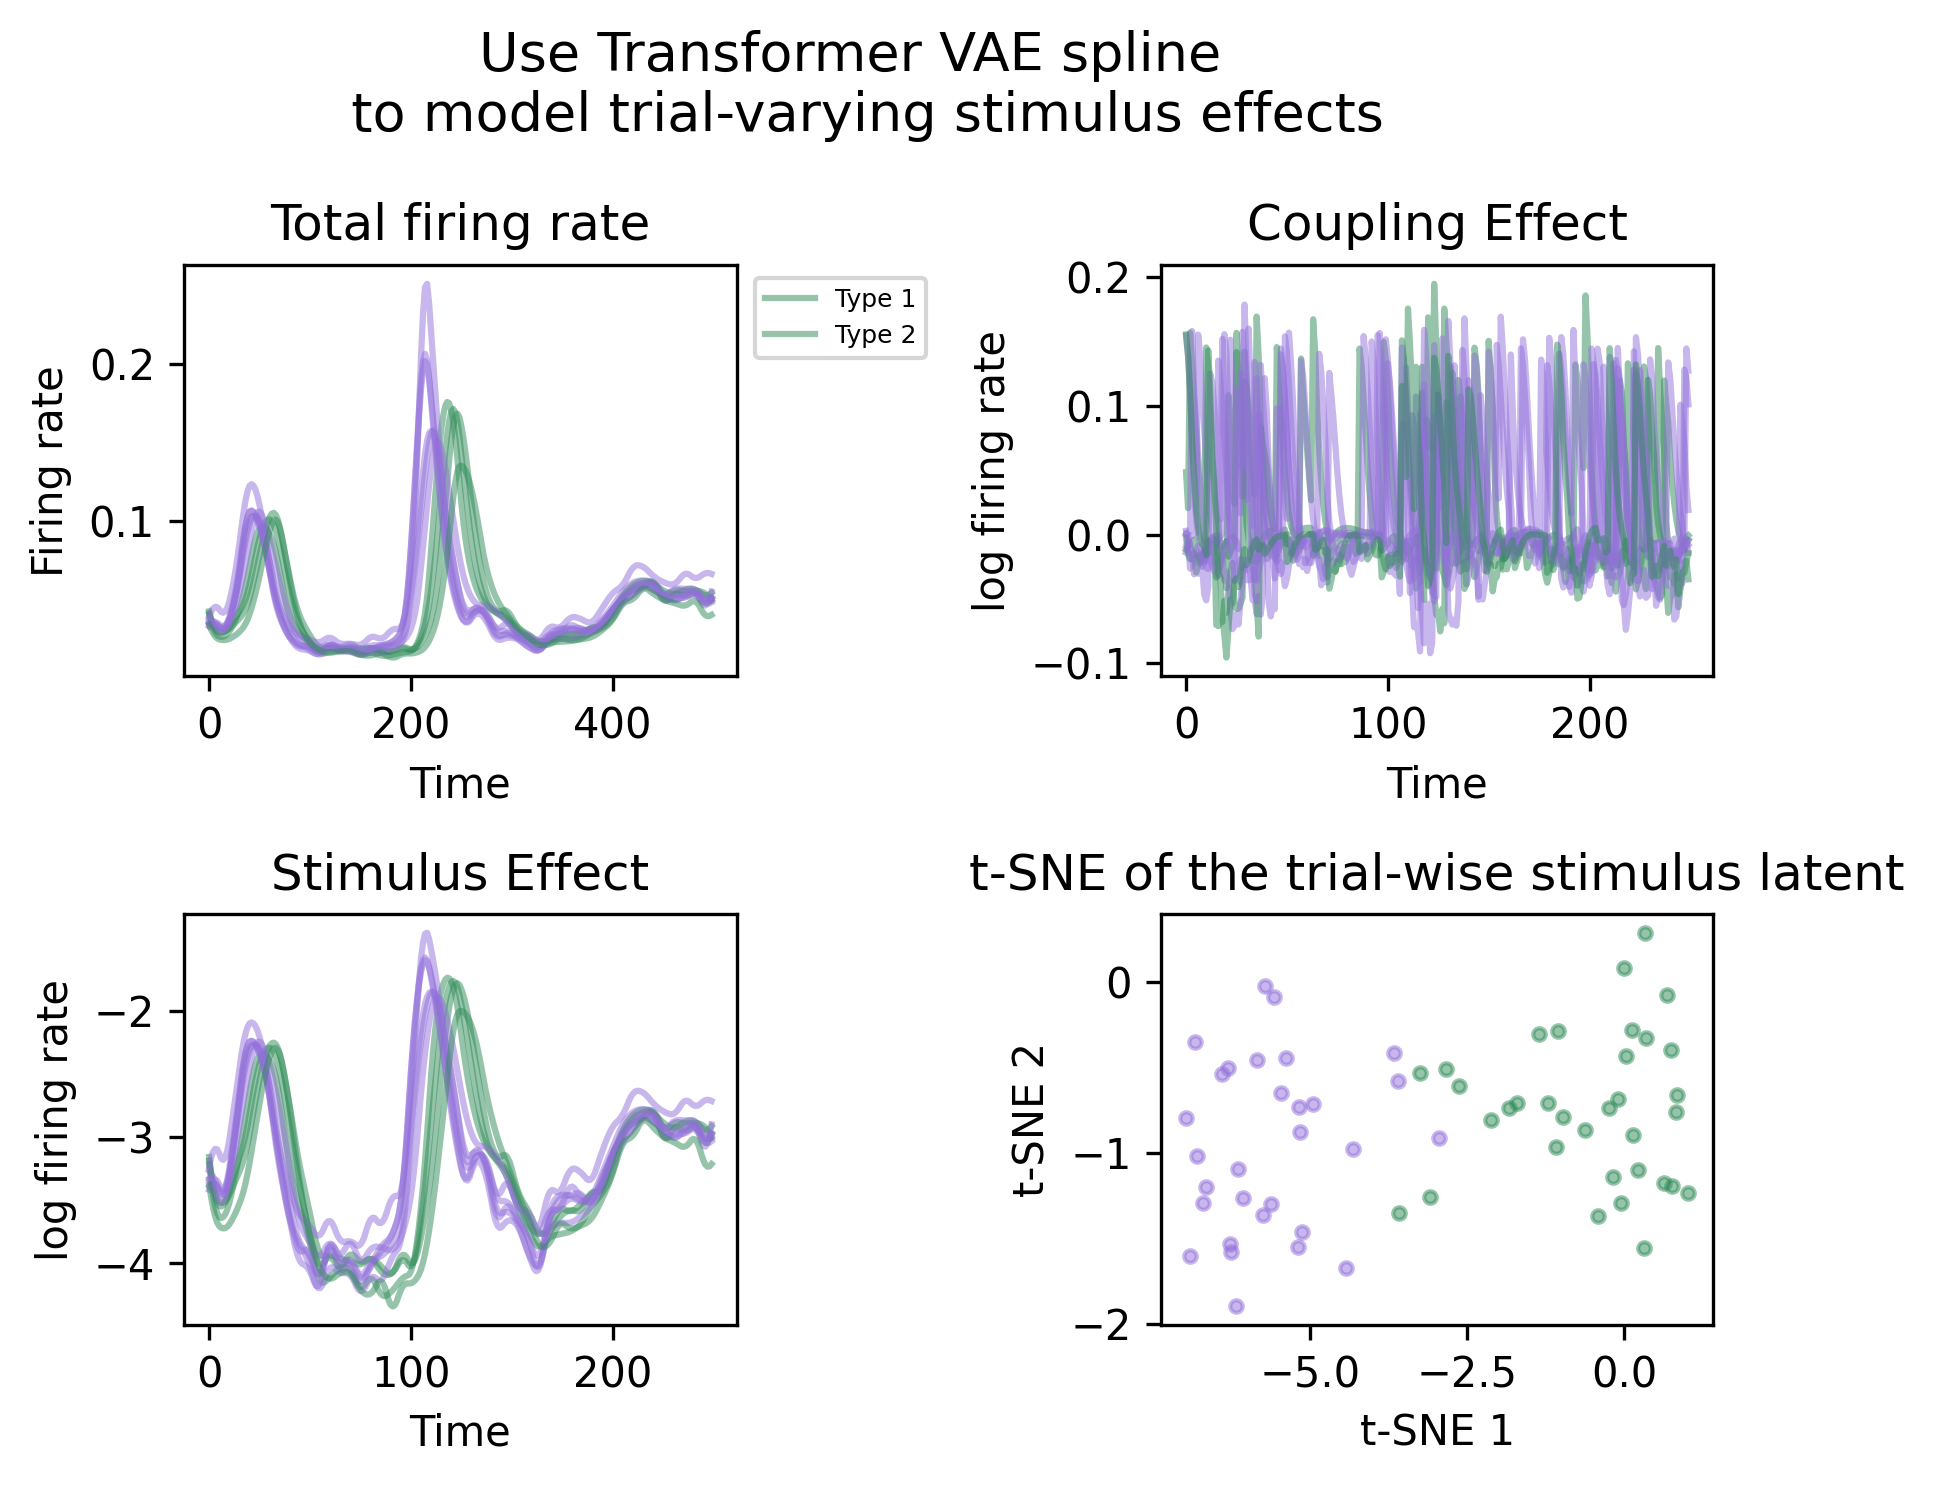

In [199]:
local_trial_indices = np.arange(0, 10)
neuron_idx = 1

firing_rate_test, sti_mu_test, sti_logvar_test, trial_indices = trainer.predict(
    dataset='test',
    batch_indices=[0],
    include_stimulus=True,
    include_coupling=False,
    fix_stimulus=False,
    fix_latents=True,
    return_torch=True,
    return_trial_indices=True,
)

# Create a 2x2 subplot figure
fig, axes = plt.subplots(2, 2, figsize=(6, 5), dpi=300)
fig.suptitle('Use Transformer VAE spline \n to model trial-varying stimulus effects', fontsize=13)

# Define better colors for the two types
type1_color = '#2E8B57'  # A nice sea green
type2_color = '#9370DB'  # A nice medium purple

# Plot total firing rate
xx = np.arange(0, len(np.exp(firing_rate_test[:, neuron_idx, local_trial_indices].numpy())), 1)*2
for i, trial_idx in enumerate(local_trial_indices):
    color = type2_color if trial_type[trial_indices[trial_idx]] else type1_color
    axes[0,0].plot(xx, np.exp(firing_rate_test[:, neuron_idx, trial_idx].numpy()), color=color, alpha=0.5)
axes[0,0].set_title('Total firing rate')
axes[0,0].set_xlabel('Time')
axes[0,0].set_ylabel('Firing rate')
axes[0,0].legend(['Type 1', 'Type 2'], bbox_to_anchor=(1.01, 1), loc='upper left', fontsize=6)

# Plot coupling effect
for i, trial_idx in enumerate(local_trial_indices):
    color = type2_color if trial_type[trial_indices[trial_idx]] else type1_color
    axes[0,1].plot(trainer.model.firing_rates_coupling[trial_idx, neuron_idx, :].cpu().numpy(), color=color, alpha=0.5)
axes[0,1].set_title('Coupling Effect')
axes[0,1].set_xlabel('Time')
axes[0,1].set_ylabel('log firing rate')

# Plot stimulus effect
for i, trial_idx in enumerate(local_trial_indices):
    color = type2_color if trial_type[trial_indices[trial_idx]] else type1_color
    axes[1,0].plot(trainer.model.firing_rates_stimulus[trial_idx, neuron_idx, :].cpu().numpy(), color=color, alpha=0.5)
axes[1,0].set_title('Stimulus Effect')
axes[1,0].set_xlabel('Time')
axes[1,0].set_ylabel('log firing rate')

# Plot t-SNE in the last subplot
sti_mu_test_np = sti_mu_test.detach().cpu().numpy() if torch.is_tensor(sti_mu_test) else sti_mu_test
if sti_mu_test_np.shape[1] <= 2:
    for i in range(len(sti_mu_test_np)):
        color = type2_color if trial_type[trial_indices[i]] else type1_color
        axes[1,1].scatter(sti_mu_test_np[i, 0], sti_mu_test_np[i, 1], alpha=0.5, marker='.', color=color)
    axes[1,1].set_title('trial-wise stimulus latent')
    axes[1,1].set_xlabel('latent dim 1')
    axes[1,1].set_ylabel('latent dim 2')
elif np.all(sti_mu_test_np.std(axis=0) > 1e-3):
    tsne = TSNE(n_components=2, random_state=42)
    sti_mu_test_tsne = tsne.fit_transform(sti_mu_test_np)
    for i in range(len(sti_mu_test_tsne)):
        color = type2_color if trial_type[trial_indices[i]] else type1_color
        axes[1,1].scatter(sti_mu_test_tsne[i, 0], sti_mu_test_tsne[i, 1], alpha=0.5, marker='.', color=color)
    axes[1,1].set_title('t-SNE of the trial-wise stimulus latent')
    axes[1,1].set_xlabel('t-SNE 1')
    axes[1,1].set_ylabel('t-SNE 2')
else:
    print(f"Stimulus latent is not varying across trials: {sti_mu_test_np.std(axis=0).mean()}")

plt.tight_layout()
# plt.savefig('Figure/all_effects_and_tsne.pdf', bbox_inches='tight', dpi=300)

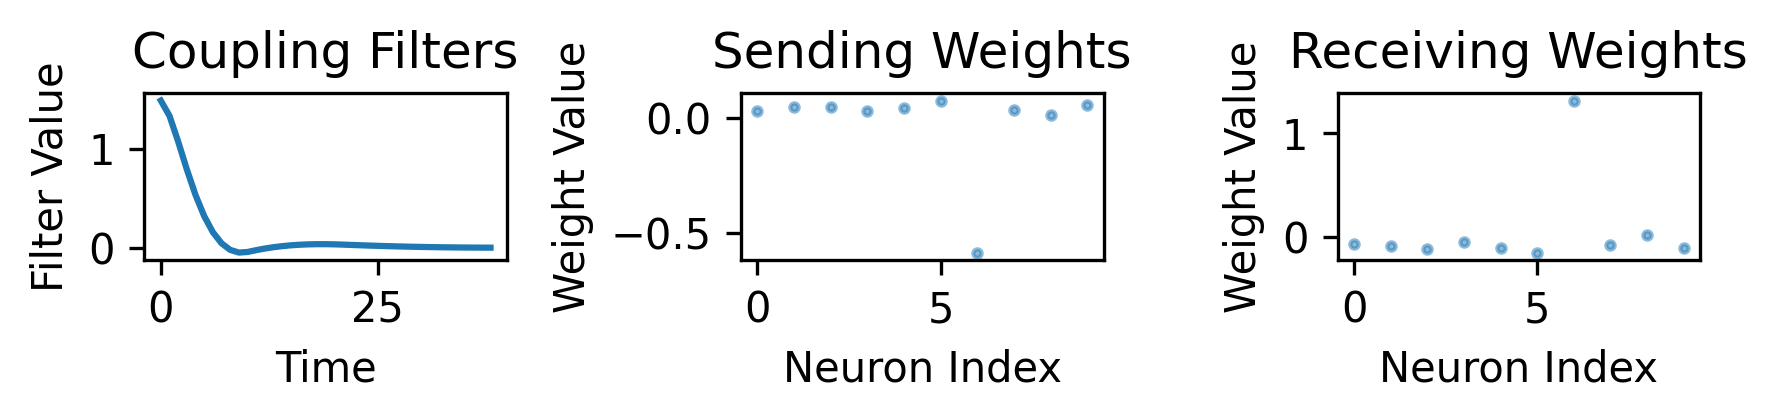

In [210]:
fig, axes = plt.subplots(1, 3, figsize=(6, 1.5), dpi=300)

# Plot coupling filters
axes[0].plot(trainer.model.coupling_filters_dict["0"][0][0].cpu().numpy())
axes[0].set_title('Coupling Filters')
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Filter Value')

# Plot sending weights 
axes[1].plot(trainer.model.cp_weight_sending_dict["0"][0][0].detach().cpu().numpy(), 
             "o", markersize=2, alpha=0.5)
axes[1].set_title('Sending Weights')
axes[1].set_xlabel('Neuron Index')
axes[1].set_ylabel('Weight Value')

# Plot receiving weights
axes[2].plot(trainer.model.cp_weight_receiving_dict["0"][0][0].detach().cpu().numpy(), 
             "o", markersize=2, alpha=0.5)
axes[2].set_title('Receiving Weights')
axes[2].set_xlabel('Neuron Index') 
axes[2].set_ylabel('Weight Value')

plt.tight_layout()


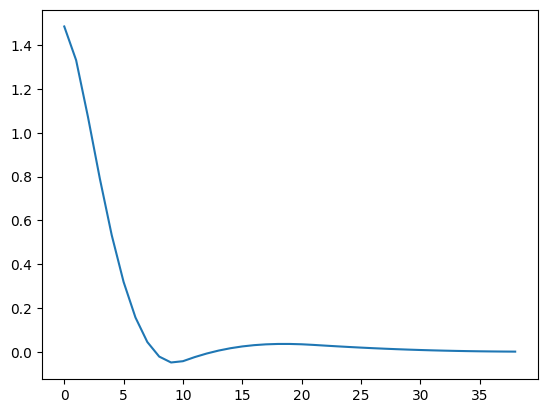

In [200]:
plt.plot(trainer.model.coupling_filters_dict["0"][0][0].cpu().numpy())

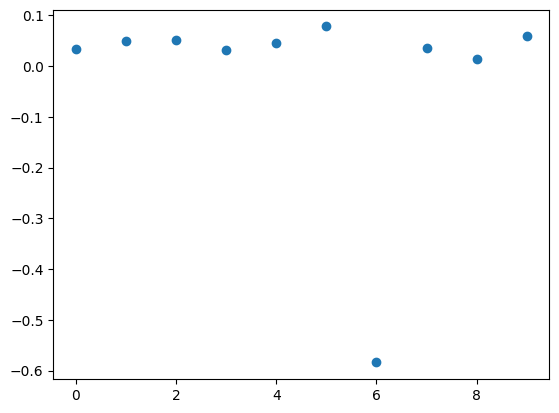

In [201]:
plt.plot(trainer.model.cp_weight_sending_dict["0"][0][0].detach().cpu().numpy(), "o")

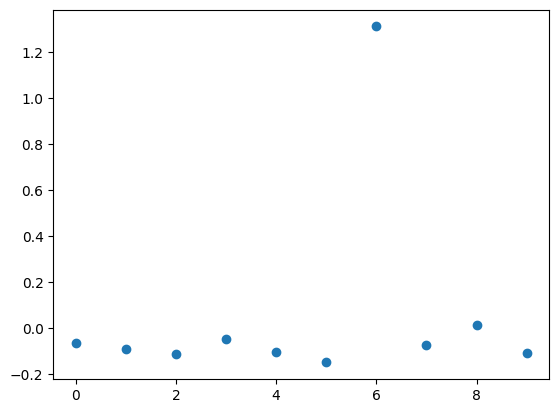

In [202]:
plt.plot(trainer.model.cp_weight_receiving_dict["0"][0][0].detach().cpu().numpy(), "o")